In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, SimpleRNN
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# Poverty level mapping for the labels
poverty_mapping = {
    "ethiopia": "High Poverty",
    "malawi": "Medium Poverty",
    "nigeria": "Low Poverty"
}


In [3]:
# Dataset path
dataset_path = "dataset"  # Replace with your dataset folder path
image_size = (128, 128)
batch_size = 32



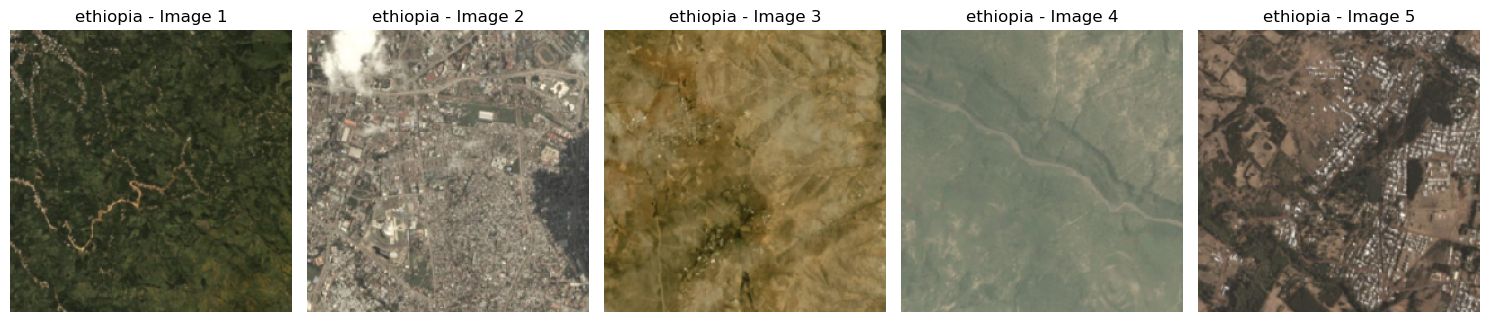

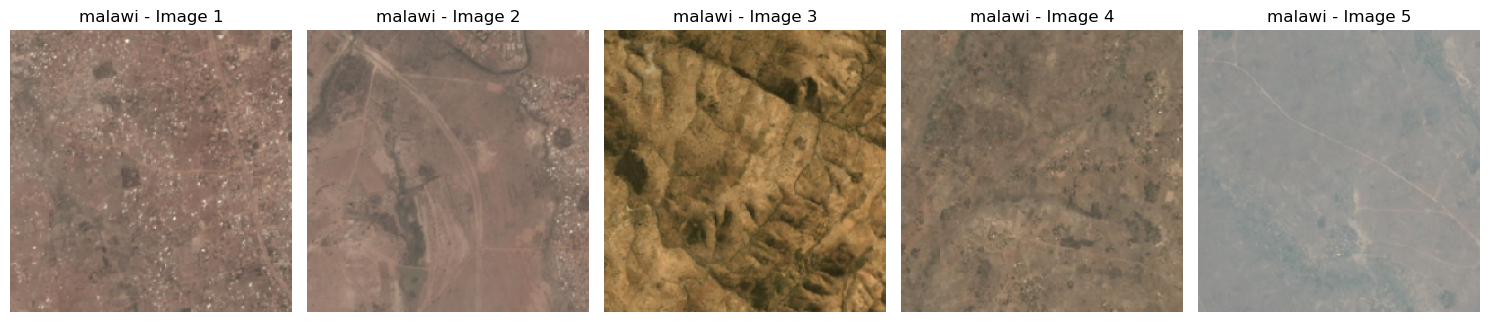

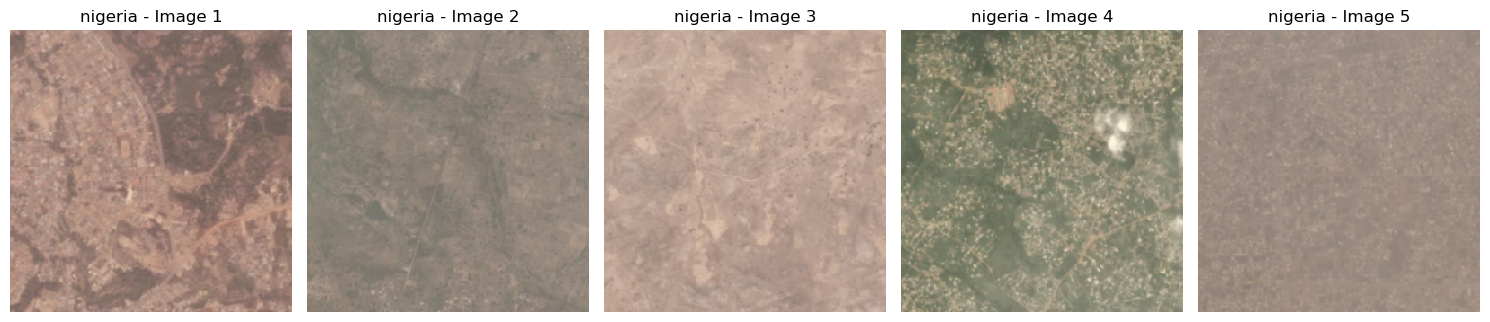

In [4]:
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.preprocessing.image import load_img

# Define your class directories (adjust the paths to your actual dataset)
class_directories = {
    "ethiopia": "dataset/ethiopia",
    "malawi": "dataset/malawi",
    "nigeria": "dataset/nigeria"
}

# Function to load and display 5 random images per class with class name
def display_images_from_class(class_name, class_path, num_images=5):
    # Load image files from the given class directory
    image_files = [f for f in os.listdir(class_path) if f.endswith('.png')]  # Adjust file extension if needed
    
    # Randomly select 5 images from the list
    selected_images = random.sample(image_files, num_images)
    
    # Load the selected images
    images = [load_img(os.path.join(class_path, img_file), target_size=(224, 224)) for img_file in selected_images]
    
    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].set_title(f"{class_name} - Image {i+1}")  # Add class name in the title
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display 5 random images for each class with class names
for class_name, class_path in class_directories.items():
    display_images_from_class(class_name, class_path, num_images=5)


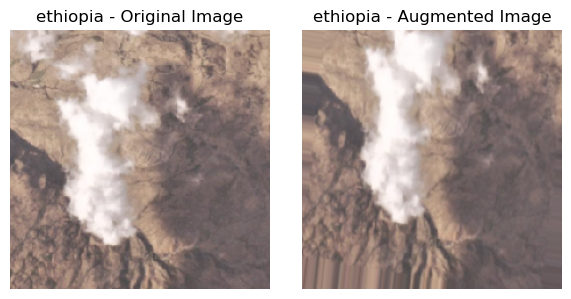

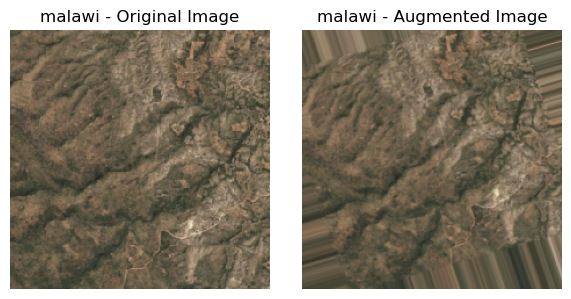

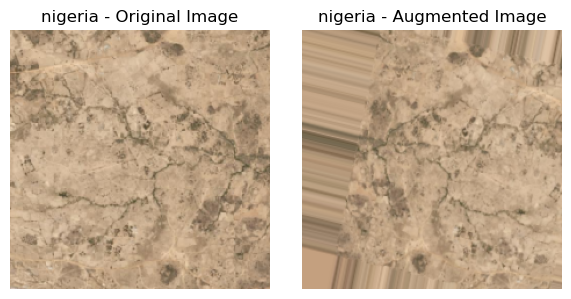

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Set up ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to the range [0, 1]
    rotation_range=40,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Random shear
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill in missing pixels after transformation
)

# Define your class directories with reversed paths (ensure correct paths are given)
class_directories = {
    "ethiopia": "dataset/ethiopia",
    "malawi": "dataset/malawi",
    "nigeria": "dataset/nigeria"
}

# Function to load and display augmented image for each class with class name
def display_augmented_image(class_name, class_path):
    # Load the first image from the given class directory
    image_files = [f for f in os.listdir(class_path) if f.endswith('.png')]  # Adjust file extension if needed
    image = load_img(os.path.join(class_path, image_files[0]), target_size=(224, 224))
    
    # Convert image to numpy array
    img_array = img_to_array(image)
    
    # Reshape for data generator
    img_array = img_array.reshape((1, 224, 224, 3))  # Reshape for the model
    
    # Generate a single augmented image
    augmented_image = datagen.flow(img_array, batch_size=1, shuffle=False)
    
    # Plot the original and augmented image with class name
    fig, axes = plt.subplots(1, 2, figsize=(6, 3)) 
    axes[0].imshow(image)
    axes[0].set_title(f"{class_name} - Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(augmented_image[0][0])
    axes[1].set_title(f"{class_name} - Augmented Image")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display one augmented image for each class with class name
for class_name, class_path in class_directories.items():
    display_augmented_image(class_name, class_path)


In [7]:
# Load the training and validation datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=42
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=42
)

# Get class names before applying .map()
class_names = train_dataset.class_names
print("Class Names:", class_names)

# Normalize the datasets using .map()
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))


Found 32822 files belonging to 3 classes.
Using 26258 files for training.
Found 32822 files belonging to 3 classes.
Using 6564 files for validation.
Class Names: ['ethiopia', 'malawi', 'nigeria']


In [8]:
# CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(class_names), activation='softmax')  # Output layer
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
cnn_model.summary()


C:\Users\harsh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Layer (type)             ┃ Output Shape      ┃   Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ conv2d (Conv2D)          │ (None, 126, 126,  │       896 │
│                          │ 32)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ max_pooling2d            │ (None, 63, 63,    │         0 │
│ (MaxPooling2D)           │ 32)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ conv2d_1 (Conv2D)        │ (None, 61, 61,    │    18,496 │
│                          │ 64)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ max_pooling2d_1          │ (None, 30, 30,    │         0 │
│ (MaxPooling2D)           │ 64)               │           │
├──────────────────────────┼───────────────────┼───────────┤
│ flatten (Flatten)        │ (None, 57600)     │         0 │
├──────────────────────────┼───────────────────┼───────────┤
│ dense (Dense)            │ (None, 128)       │ 7,372,928 │
├──────────────────────────┼───────────────────┼───────────┤
│ dense_1 (Dense)          │ (None, 3)         │       387 │
└──────────────────────────┴───────────────────┴───────────┘

 Total params: 7,392,707 (28.20 MB)

 Trainable params: 7,392,707 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the CNN model
cnn_history = cnn_model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Save the CNN model
cnn_model.save("cnn_model.h5")


Epoch 1/10
697/821 ━━━━━━━━━━━━━━━━━━━━ 47s 387ms/step - accuracy: 0.5073 - loss: 1.1032 

In [9]:
# RNN model
rnn_model = Sequential([
    Reshape((128, 128*3), input_shape=(128, 128, 3)),  # Flatten image spatially for sequence processing
    SimpleRNN(128, activation='relu', return_sequences=True),
    SimpleRNN(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(len(class_names), activation='softmax')  # Output layer
])

# Compile the RNN model
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
rnn_model.summary()


C:\Users\harsh\anaconda3\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 128, 384)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 128, 128)            │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 86,723 (338.76 KB)

 Trainable params: 86,723 (338.76 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the RNN model
rnn_history = rnn_model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Save the RNN model
rnn_model.save("rnn_model.h5")


Epoch 1/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 138s 158ms/step - accuracy: 0.4659 - loss: 1.0137 - val_accuracy: 0.5807 - val_loss: 0.9109
Epoch 2/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 127s 155ms/step - accuracy: 0.5662 - loss: 0.9240 - val_accuracy: 0.6030 - val_loss: 0.8872
Epoch 3/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 124s 151ms/step - accuracy: 0.5814 - loss: 0.9005 - val_accuracy: 0.6210 - val_loss: 0.8336
Epoch 4/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 123s 150ms/step - accuracy: 0.6092 - loss: 0.8584 - val_accuracy: 0.6527 - val_loss: 0.7743
Epoch 5/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 132s 161ms/step - accuracy: 0.6356 - loss: 0.8081 - val_accuracy: 0.6699 - val_loss: 0.7386
Epoch 6/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 155s 189ms/step - accuracy: 0.6556 - loss: 0.7758 - val_accuracy: 0.6729 - val_loss: 0.7440
Epoch 7/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 138s 168ms/step - accuracy: 0.6479 - loss: 0.7970 - val_accuracy: 0.5821 - val_loss: 0.9082
Epoch 8/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 132s 160ms/step - accuracy: 0.6265 -

In [12]:
from sklearn.metrics import classification_report

# Helper function to get predictions and labels
def get_predictions_and_labels(model, dataset):
    y_true, y_pred = [], []
    for images, labels in dataset:
        preds = model.predict(images,verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    return np.array(y_true), np.array(y_pred)

# Evaluate CNN
cnn_y_true, cnn_y_pred = get_predictions_and_labels(cnn_model, val_dataset)
print("CNN Classification Report:\n", classification_report(cnn_y_true, cnn_y_pred, target_names=class_names))

# Evaluate RNN
rnn_y_true, rnn_y_pred = get_predictions_and_labels(rnn_model, val_dataset)
print("RNN Classification Report:\n", classification_report(rnn_y_true, rnn_y_pred, target_names=class_names))


CNN Classification Report:
               precision    recall  f1-score   support

    ethiopia       0.84      0.77      0.80      1690
      malawi       0.87      0.85      0.86      2494
     nigeria       0.85      0.92      0.89      2380

    accuracy                           0.86      6564
   macro avg       0.85      0.85      0.85      6564
weighted avg       0.86      0.86      0.86      6564

RNN Classification Report:
               precision    recall  f1-score   support

    ethiopia       0.64      0.55      0.59      1690
      malawi       0.73      0.62      0.67      2494
     nigeria       0.65      0.82      0.73      2380

    accuracy                           0.68      6564
   macro avg       0.68      0.66      0.66      6564
weighted avg       0.68      0.68      0.67      6564



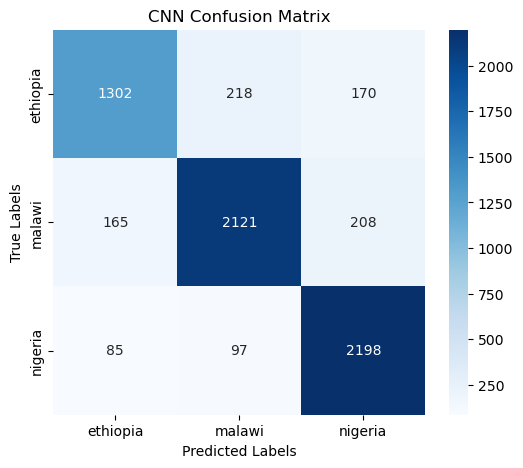

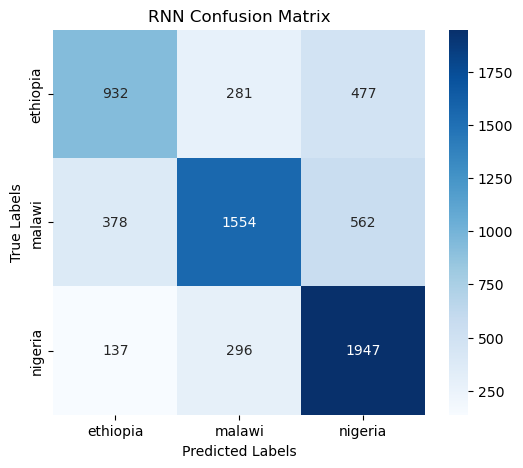

In [13]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# CNN Confusion Matrix
plot_confusion_matrix(cnn_y_true, cnn_y_pred, "CNN Confusion Matrix")

# RNN Confusion Matrix
plot_confusion_matrix(rnn_y_true, rnn_y_pred, "RNN Confusion Matrix")


In [25]:
from tensorflow.keras.preprocessing import image

# Predict function with poverty levels
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(128, 128))  # Resize image
    img_array = image.img_to_array(img) / 255.0            # Normalize image
    img_array = np.expand_dims(img_array, axis=0)          # Add batch dimension
    predictions = model.predict(img_array,verbose=0)
    
    # Get the predicted class and map to poverty level
    predicted_class = np.argmax(predictions)
    class_name = class_names[predicted_class]
    poverty_level = poverty_mapping[class_name]
    return class_name, poverty_level

# Test with a sample image
test_img_path = "dataset/nigeria/4.8273254021_8.03775303243402_4.8273254021_8.082668796639997.png"  # Replace with your image path
predicted_class, poverty_level = predict_image(cnn_model, test_img_path)
print(f"Predicted Class: {predicted_class}")
print(f"Poverty Level: {poverty_level}")


Predicted Class: nigeria
Poverty Level: Low Poverty


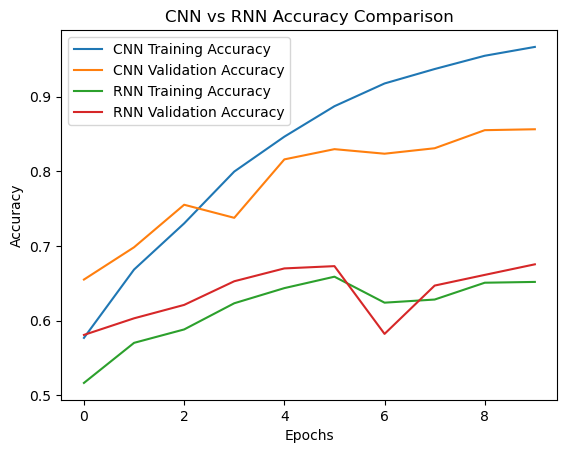

In [26]:
# Plot training and validation accuracy
plt.plot(cnn_history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.plot(rnn_history.history['accuracy'], label='RNN Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN vs RNN Accuracy Comparison')
plt.legend()
plt.show()
